# Analysis of suspiscion of endometriosis detection

the objective of this analysis is to detect if some users have symptoms of endometriosis, that is accute pain during period ("cramp" in the data). We isolate the users with most accurate pain at J1 of the cycle, and observe their other symptoms. Although the sample is small we see that this "severe pain" population (16 patients) exhibits high intensity of other endometriosis symptoms: backpain, bloating, sore, but not for other symptoms, like diarrhea or dizziness. A larger sample is needed to have deeper statistical analyses.

The ideal would be to have the endometriosis diagnosis in the data themselves (i.e. the app asks users), so that the diagnosis could maybe be predicted for other similar patients, to improve suspiscion of endometriosis detection

In [1]:
import pandas as pd
from datetime import datetime
import numpy as np
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
m_symptoms = pd.read_csv('data/clean_symptom.csv')
symptom_cols = ['acne', 'backache', 'bloating', 'cramp', 'diarrhea', 'dizzy',
                'headache', 'mood', 'nausea', 'sore']
reduced_symptoms = ['acne', 'backache', 'bloating', 'cramp', 
                'headache', 'mood', 'sore']

In [3]:
m_symptoms = m_symptoms.assign(percent_cycle=m_symptoms.day_of_cycle/m_symptoms.cycle_length)
m_symptoms = m_symptoms.assign(normalized_day_cycle=pd.Categorical(np.round(m_symptoms.percent_cycle*28)+1, ordered=True, categories=range(1, 29)))

In [4]:
m_symptoms = m_symptoms.assign(nb_row_user = m_symptoms.user_id.map(m_symptoms.user_id.value_counts()))
m_symptoms = m_symptoms.assign(nb_cycle_user = m_symptoms.user_id.map(m_symptoms.groupby('user_id').start_date.nunique()))
m_symptoms[symptom_cols] = m_symptoms[symptom_cols].replace({0:np.nan})

/Users/JudithAbecassis/my_python35/lib/python3.5/site-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
/Users/JudithAbecassis/my_python35/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


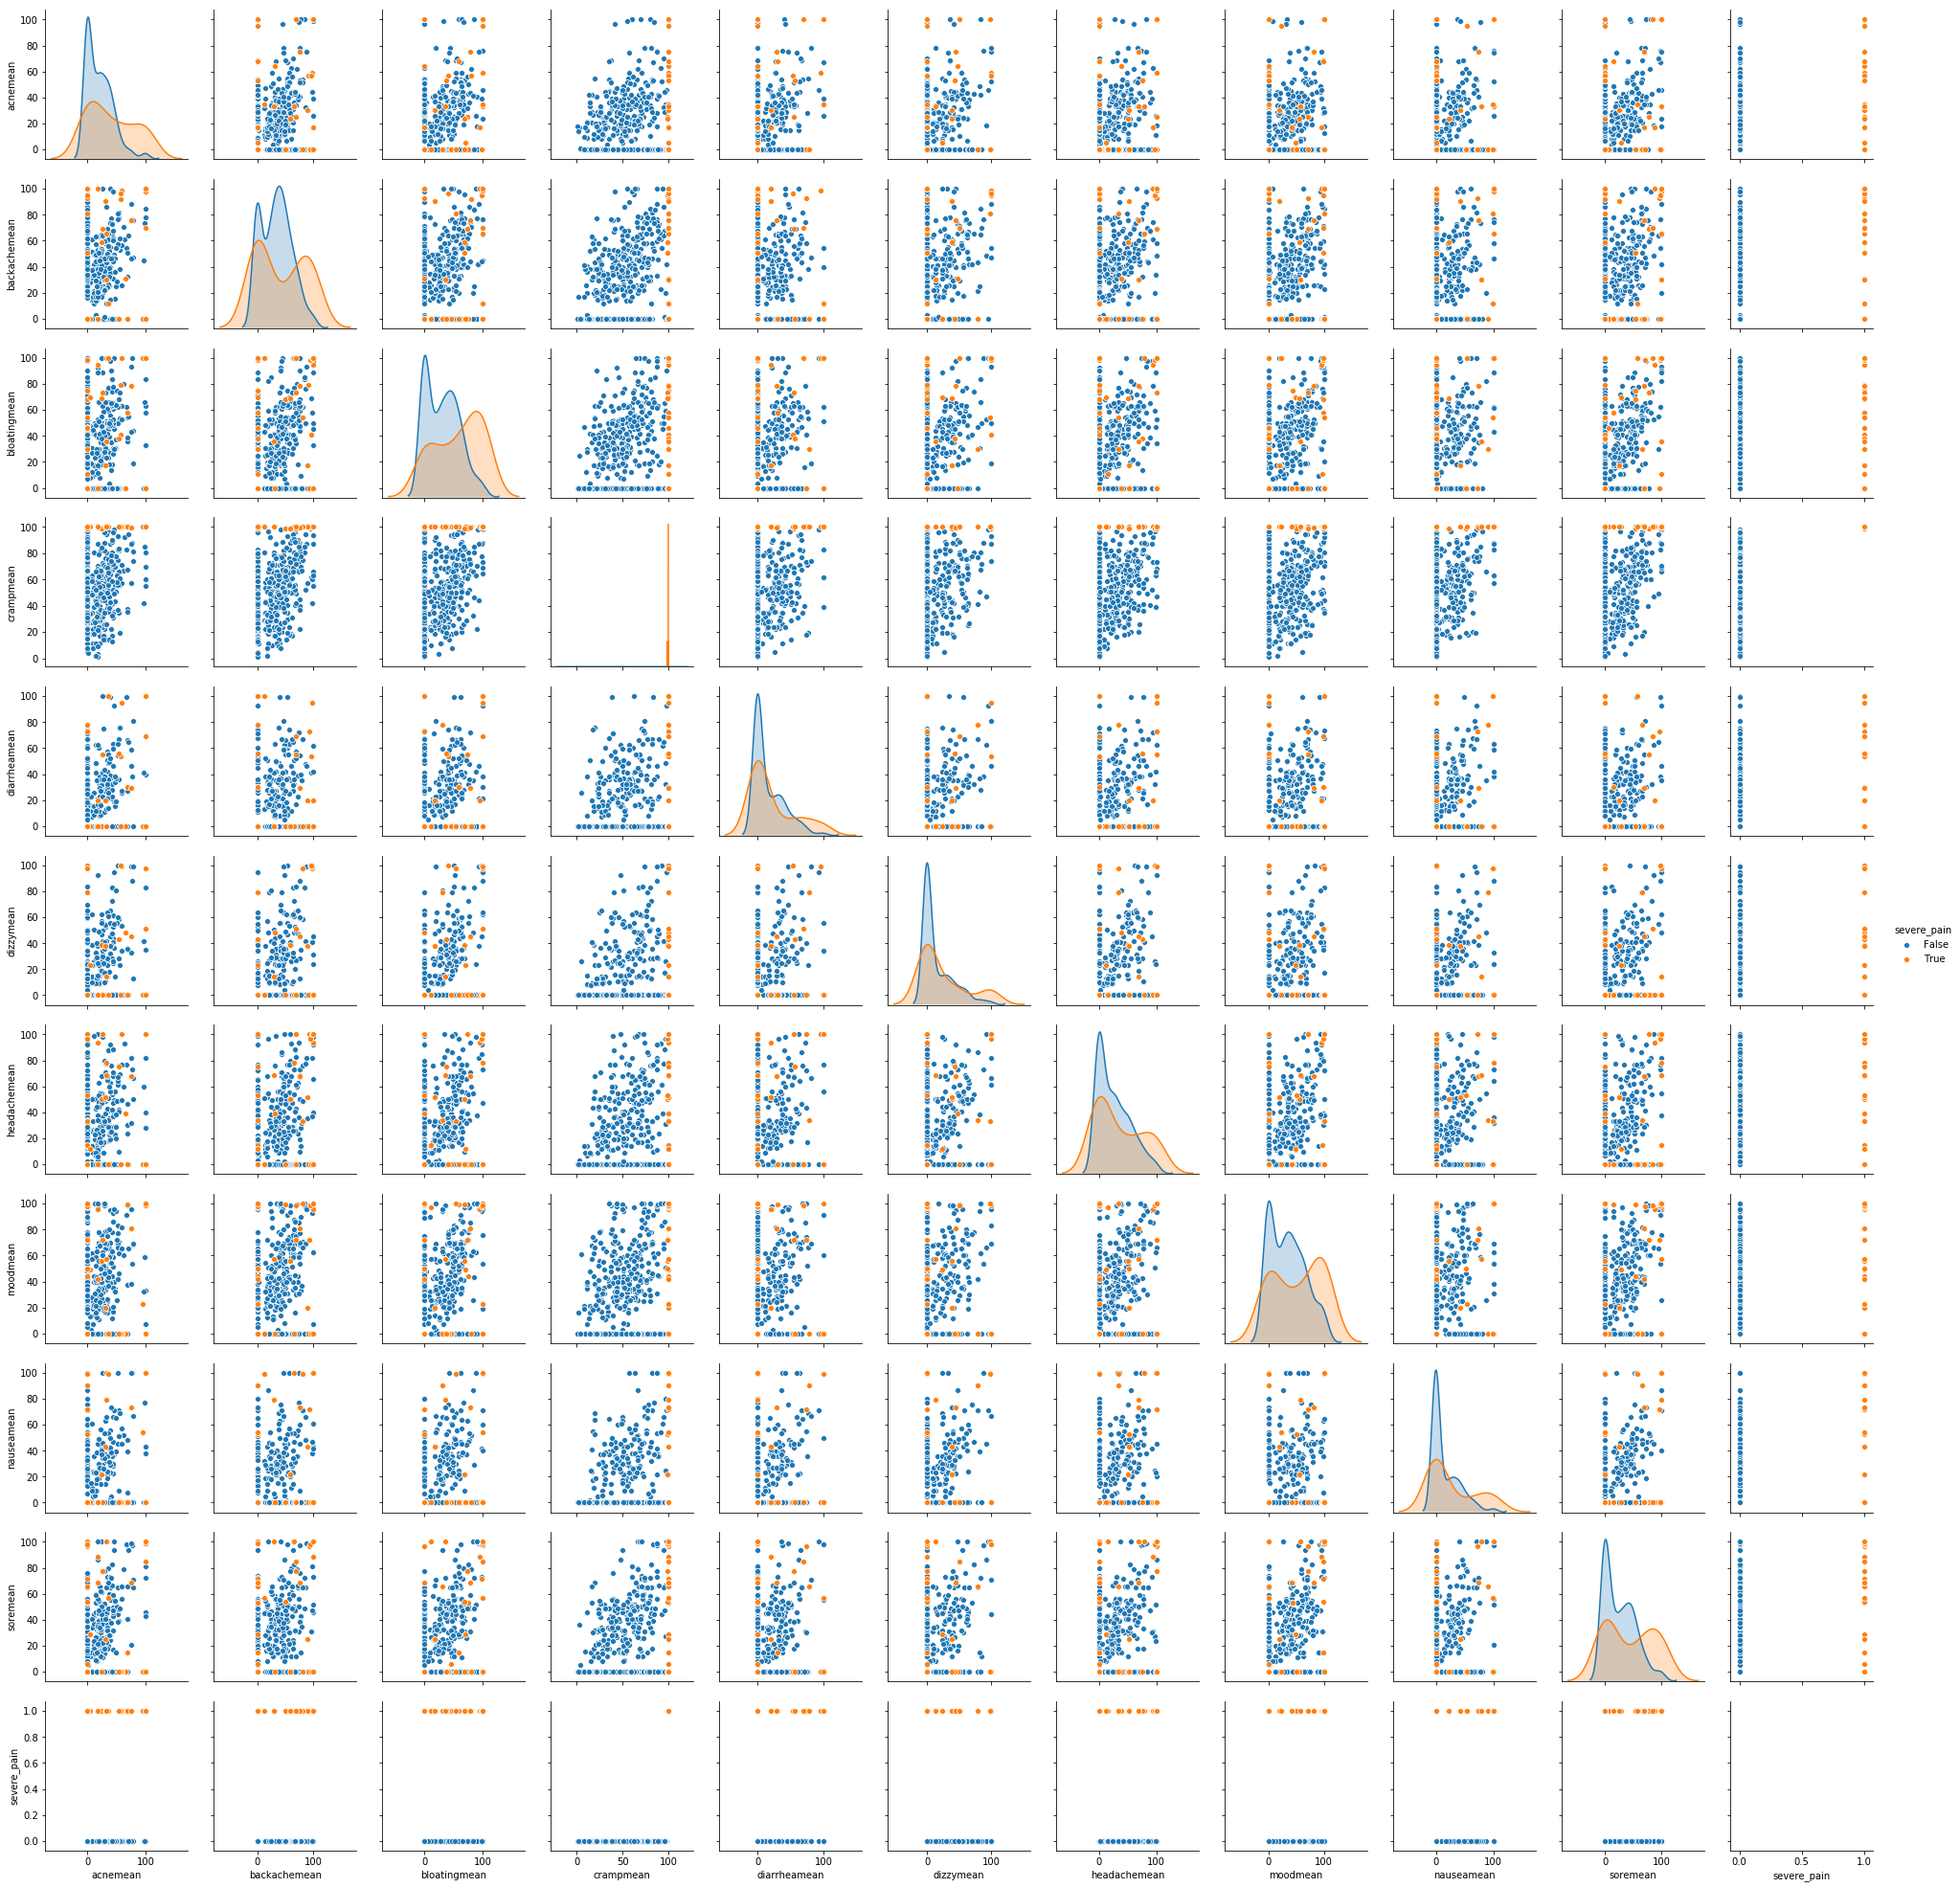

In [5]:
qcols = ['{}_J1_q'.format(s) for s in symptom_cols]
reduced_data = m_symptoms[(m_symptoms.nb_cycle_user>=3)&(m_symptoms.normalized_day_cycle==1)]
mapping_cols = {'{}_J1_q'.format(s): reduced_data[s].rank(pct=True) for s in symptom_cols}
reduced_data = reduced_data.assign(**mapping_cols)
reduced_data = reduced_data.assign(severe_pain=reduced_data.cramp_J1_q>0.9)
f = {c:['mean'] for c in symptom_cols}
f['cramp'] = ['mean', 'std']
piv = reduced_data.groupby('user_id').agg(f)
new_cols = [''.join(t) for t in piv.columns]
piv.columns = new_cols
piv = piv.assign(severe_pain=piv.crampmean.rank(pct=True)>0.9)
g=sns.pairplot(piv[['{}mean'.format(s) for s in symptom_cols] + ['severe_pain']].dropna(subset=['crampmean']).dropna(thresh=3).fillna(0), hue='severe_pain')
